In [88]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from torchvision.transforms.functional import resize

# **Checking GPU**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 2060


# **Histogram Image Size**

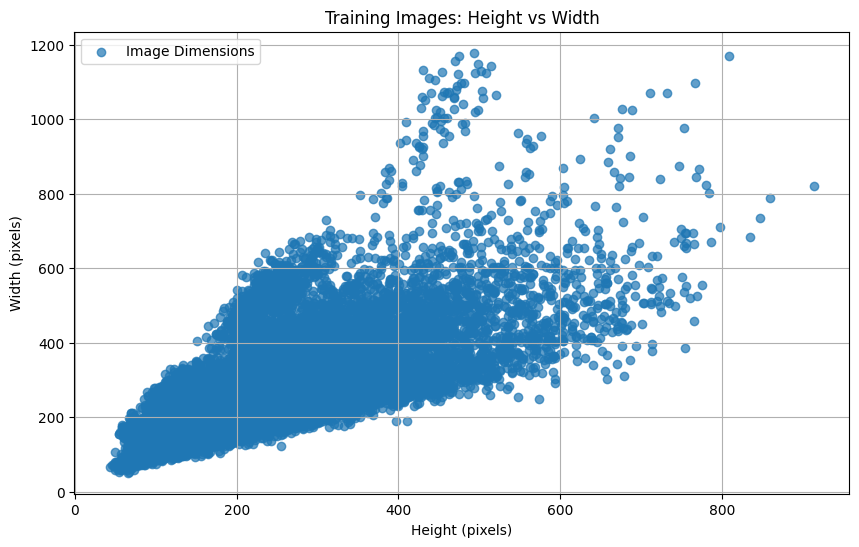

In [75]:
def process_image(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def collect_dimensions(image_dir):
    dimensions = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                futures.append(executor.submit(process_image, file_path))

        for future in futures:
            result = future.result()
            if result:
                dimensions.append(result)

    return dimensions

def plot_histogram(dimensions, title):
    heights = [dim[1] for dim in dimensions]
    widths = [dim[0] for dim in dimensions]

    plt.figure(figsize=(10, 6))
    plt.scatter(heights, widths, alpha=0.7, label="Image Dimensions")
    plt.title(title)
    plt.xlabel("Height (pixels)")
    plt.ylabel("Width (pixels)")
    plt.grid(True)
    plt.legend()
    plt.show()

train_dir = "D:\\Computer Vision\\FYP\\TASK 1\\env\\TrackNet-X\\DataSet\\VeRi\\image_train"

train_dimensions = collect_dimensions(train_dir)

if train_dimensions:
    plot_histogram(train_dimensions, "Training Images: Height vs Width")
else:
    print("No dimensions collected for training images.")

# **Dataset Loading & Triplet Generator**

In [4]:
class VERIDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for img_name in os.listdir(data_dir):
            if img_name.endswith('.jpg'):
                self.image_paths.append(img_name)
                car_id = int(img_name.split('_')[0])
                self.labels.append(car_id)

        # Create a mapping for car IDs to indices
        self.id_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in self.id_to_indices:
                self.id_to_indices[label] = []
            self.id_to_indices[label].append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = os.path.join(self.data_dir, self.image_paths[index])
        label = self.labels[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_triplet(self):
        ids_list = random.sample(self.id_to_indices.keys(), 1)[0]
        anchor_idx = random.choice(self.id_to_indices[ids_list])
        positive_idx = random.choice(self.id_to_indices[ids_list])

        # Ensure negative is from a different ID
        negative_ids = list(self.id_to_indices.keys())
        negative_ids.remove(ids_list)
        negative_id = random.choice(negative_ids)
        negative_idx = random.choice(self.id_to_indices[negative_id])

        return anchor_idx, positive_idx, negative_idx

# **Loaded Data**

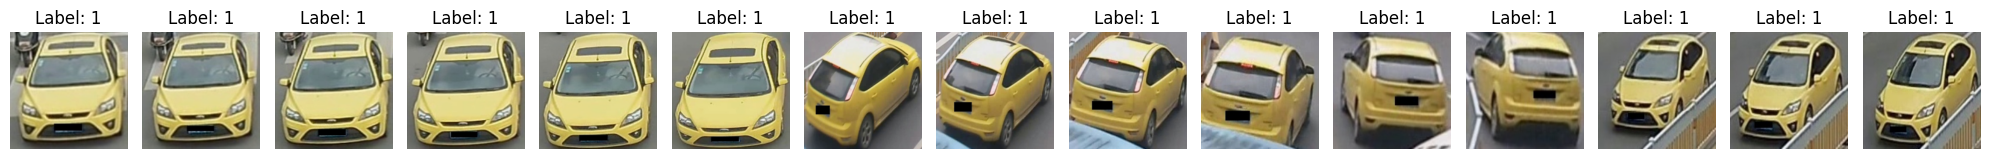

In [66]:
data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train'
transform = transforms.Compose([transforms.Resize((196, 196)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = VERIDataset(data_dir, transform=transform)

num_samples = 15
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    img, label = dataset[i]
    img_np = img.permute(1, 2, 0).numpy() 
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = (img_np * 255).astype('uint8')

    axes[i].imshow(img_np)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [6]:
class TripletDataset(Dataset):
    def __init__(self, veri_dataset):
        self.veri_dataset = veri_dataset

    def __len__(self):
        return len(self.veri_dataset)

    def __getitem__(self, index):
        anchor_idx, positive_idx, negative_idx = self.veri_dataset.get_triplet()
        anchor, _ = self.veri_dataset[anchor_idx]
        positive, _ = self.veri_dataset[positive_idx]
        negative, _ = self.veri_dataset[negative_idx]
        return anchor, positive, negative

# **Checking Generated Triplets**

C:\Users\ahmad\AppData\Local\Temp\ipykernel_14380\2779224039.py:33: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  ids_list = random.sample(self.id_to_indices.keys(), 1)[0]


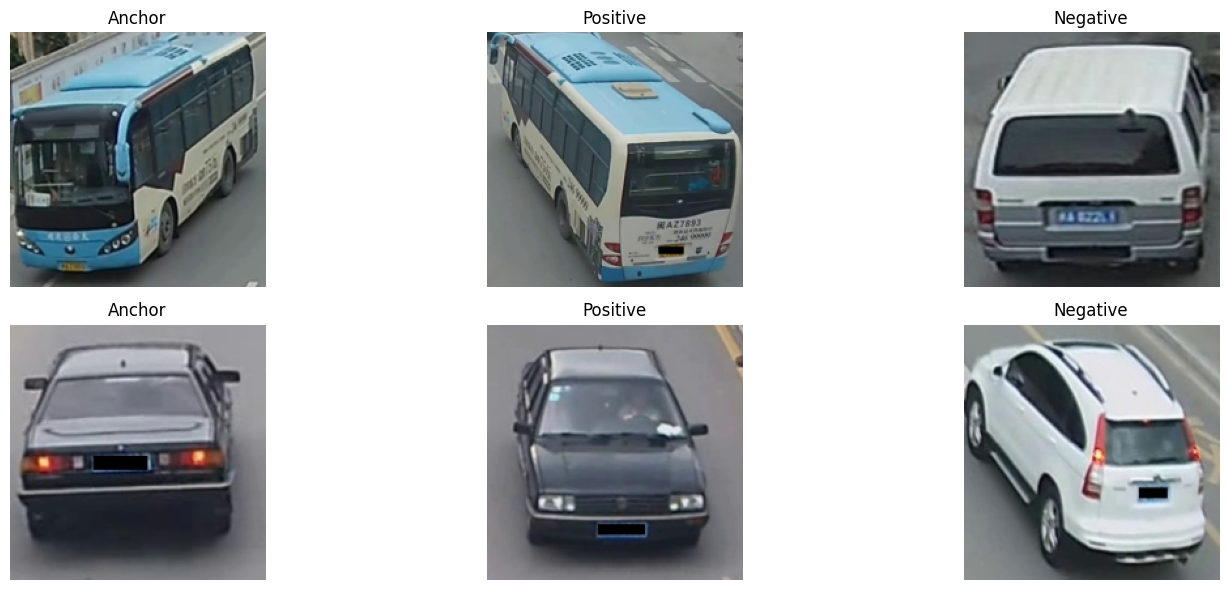

In [76]:
data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train'
transform = transforms.Compose([transforms.Resize((196, 196)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
veri_dataset = VERIDataset(data_dir, transform=transform)

triplet_dataset = TripletDataset(veri_dataset)

num_samples = 2
fig, axes = plt.subplots(num_samples, 3, figsize=(16, 6))

for i in range(num_samples):
    anchor, positive, negative = triplet_dataset[i]

    def to_numpy(tensor_img):
        img_np = tensor_img.permute(1, 2, 0).numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_np = (img_np * 255).astype('uint8')  
        return img_np

    axes[i, 0].imshow(to_numpy(anchor))
    axes[i, 0].set_title("Anchor")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(to_numpy(positive))
    axes[i, 1].set_title("Positive")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(to_numpy(negative))
    axes[i, 2].set_title("Negative")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# **Custom CNN**

In [7]:
class TripletCNN(nn.Module):
    def __init__(self):
        super(TripletCNN, self).__init__()

        # First convolution layer: 7x7 kernel, stride 5, padding 3, 12 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=5, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)  # No downsampling here

        # Second convolution layer: 3x3 kernel, stride 1, padding 1, 24 channels
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

        # Third convolution layer: 3x3 kernel, stride 1, padding 1, 32 channels (no downsampling)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces to 32x32

        # Fourth convolution layer: 3x3 kernel, stride 1, padding 1, 64 channels (no downsampling)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Adaptive pooling to prevent size issues
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Flatten()

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = self.pool1(x1)

        x3 = F.relu(self.conv2(x2))
        x4 = F.relu(self.conv3(x3))
        x5 = self.pool2(x4)

        x6 = F.relu(self.conv4(x5))
        x7 = self.global_pool(x6)
        x8 = self.fc(x7)

        return x8

# **Triplet Loss**

In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin=3.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.nn.functional.pairwise_distance(anchor, positive)
        neg_dist = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0.0).mean()
        return loss

# **Training**

In [14]:
def calculate_accuracy(anchor_out, positive_out, negative_out):
    pos_dist = torch.nn.functional.pairwise_distance(anchor_out, positive_out)
    neg_dist = torch.nn.functional.pairwise_distance(anchor_out, negative_out)
    correct = (pos_dist < neg_dist).sum().item()
    accuracy = correct / anchor_out.size(0)
    return accuracy

In [15]:
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.to(device)
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            # Calculate loss and backpropagate
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            accuracy = calculate_accuracy(anchor_out, positive_out, negative_out)

            train_loss += loss.item()
            train_accuracy += accuracy

        # Calculate average loss and accuracy for training
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        
    return train_losses, train_accuracies

# **Accuracy and Loss Curves**

In [16]:
def plot_learning_curves(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Main Function**

C:\Users\ahmad\AppData\Local\Temp\ipykernel_14380\2779224039.py:33: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  ids_list = random.sample(self.id_to_indices.keys(), 1)[0]


Epoch 1/40 - Train Loss: 2.2124, Train Accuracy: 0.6799
Epoch 2/40 - Train Loss: 1.4974, Train Accuracy: 0.7846
Epoch 3/40 - Train Loss: 1.4133, Train Accuracy: 0.7978
Epoch 4/40 - Train Loss: 1.3363, Train Accuracy: 0.8085
Epoch 5/40 - Train Loss: 1.2841, Train Accuracy: 0.8168
Epoch 6/40 - Train Loss: 1.2012, Train Accuracy: 0.8281
Epoch 7/40 - Train Loss: 1.1650, Train Accuracy: 0.8360
Epoch 8/40 - Train Loss: 1.1415, Train Accuracy: 0.8387
Epoch 9/40 - Train Loss: 1.1053, Train Accuracy: 0.8443
Epoch 10/40 - Train Loss: 1.0714, Train Accuracy: 0.8497
Epoch 11/40 - Train Loss: 1.0521, Train Accuracy: 0.8510
Epoch 12/40 - Train Loss: 1.0274, Train Accuracy: 0.8539
Epoch 13/40 - Train Loss: 1.0385, Train Accuracy: 0.8523
Epoch 14/40 - Train Loss: 1.0094, Train Accuracy: 0.8575
Epoch 15/40 - Train Loss: 0.9989, Train Accuracy: 0.8584
Epoch 16/40 - Train Loss: 1.0077, Train Accuracy: 0.8553
Epoch 17/40 - Train Loss: 0.9783, Train Accuracy: 0.8605
Epoch 18/40 - Train Loss: 0.9753, Train 

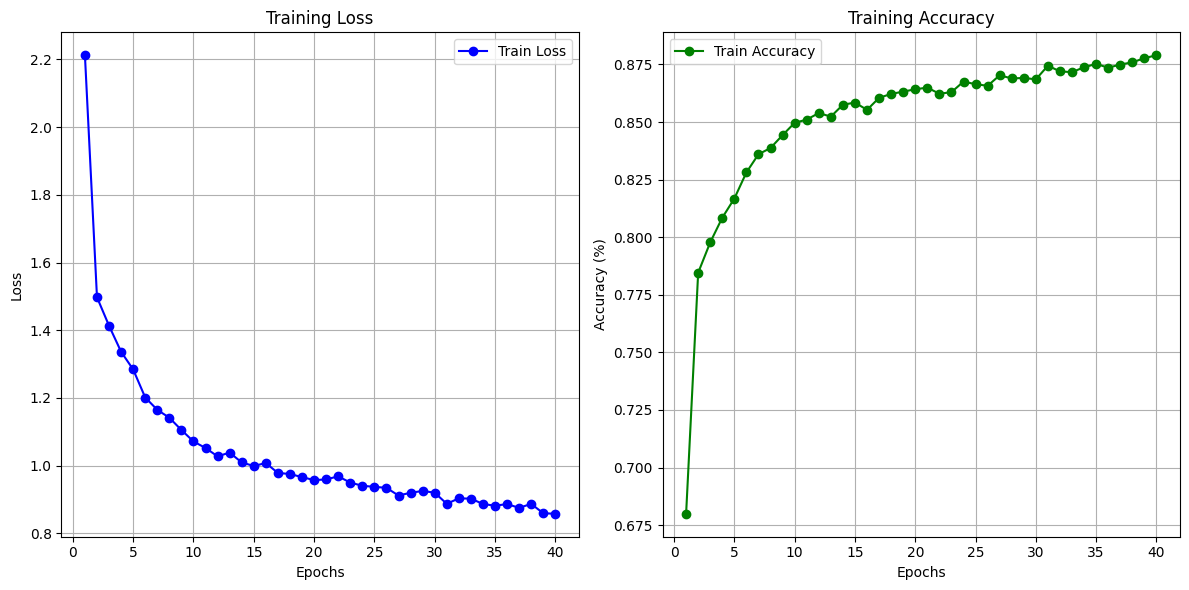

In [17]:
def main():
    data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train'
    transform = transforms.Compose([transforms.Resize((196, 196)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    full_dataset = VERIDataset(data_dir, transform)

    train_triplet_dataset = TripletDataset(full_dataset)
    train_loader = DataLoader(train_triplet_dataset, batch_size=128, shuffle=True)

    # Initialize the model, optimizer, and loss function
    model = TripletCNN()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = TripletLoss()

    train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, device, epochs=40)
    plot_learning_curves(train_losses, train_accuracies)
    torch.save(model.state_dict(), 'triplet_cnn.pth')

if __name__ == "__main__":
    main()

# **Test on Data**

In [82]:
model_path = 'triplet_cnn.pth'
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to preprocess images
def preprocess_image(image_path, transform):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension (1, C, H, W)
    return img

def compute_distance(model, image1_path, image2_path, transform, margin=3.0, device='cuda'):
    image1 = preprocess_image(image1_path, transform).to(device)
    image2 = preprocess_image(image2_path, transform).to(device)
    
    with torch.no_grad():
        feature1 = model(image1)
        feature2 = model(image2)
    
    distance = F.pairwise_distance(feature1, feature2,p=2).item()
    similarity = distance < margin
    
    if similarity:
        print(f"Images are similar (distance: {distance:.4f})")
    else:
        print(f"Images are different (distance: {distance:.4f})")
    
    return distance, similarity

def main():

    image1_path = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_test\0061_c003_00083765_0.jpg'  
    image2_path = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_test\0061_c004_00083765_0.jpg'
    
    transform = transforms.Compose([transforms.Resize((196, 196)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    model = TripletCNN().to(device)
    model = load_model(model, model_path)
    
    distance, similarity = compute_distance(model, image1_path, image2_path, transform, margin=3.0, device=device)

if __name__ == "__main__":
    main()

Images are different (distance: 4.2725)


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14380\1139347847.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


# **DataSet Visualization**

d:\Computer Vision\FYP\TASK 1\env\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_14380\232216311.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


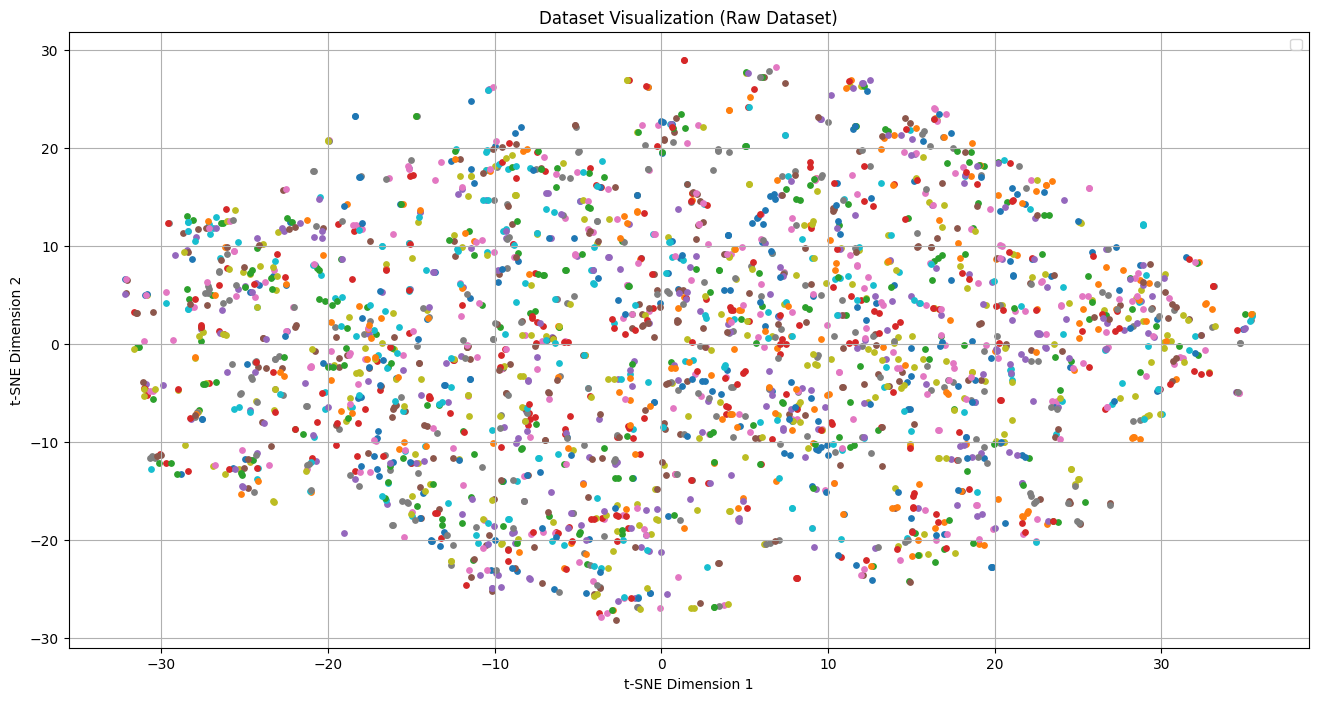

In [92]:
def plot_dataset_embeddings(dataset, device, title_suffix="", max_samples=None):
    sampled_indices = torch.randperm(len(dataset))[:max_samples].tolist()

    embeddings = []
    labels = []

    for idx in sampled_indices:
        img, label = dataset[idx]
        # Resize the image to a smaller size to reduce dimensionality
        img = resize(img, (32, 32)).numpy().flatten()  # Flatten the resized image
        embeddings.append(img)
        labels.append(label)  # Append scalar label

    # Convert embeddings and labels to NumPy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Use t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(16, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        # plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1],label=f"Class {label}", s=15)
        plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1], s=15)

    plt.title(f"Dataset Visualization {title_suffix}")
    plt.legend()
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

plot_dataset_embeddings(dataset=full_dataset,device=device, title_suffix="(Raw Dataset)", max_samples=2500)

# **Model Visualization**

C:\Users\ahmad\AppData\Local\Temp\ipykernel_14380\45357338.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('triplet_cnn.pth', map_locat

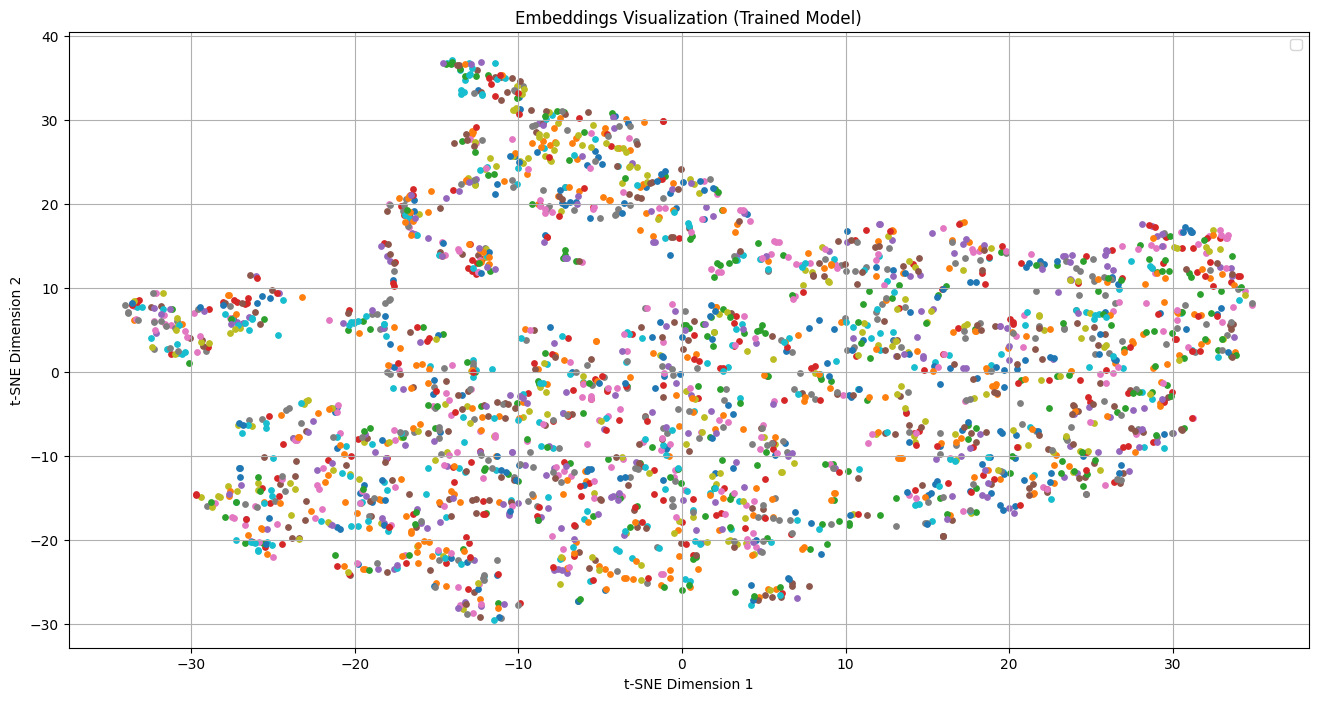

In [91]:
def plot_triplet_embeddings(model, dataset, device, title_suffix="", max_samples=None):
    model.to(device)
    model.eval()

    embeddings = []
    labels = []

    # Randomly sample max_samples items from the dataset
    sampled_indices = torch.randperm(len(dataset))[:max_samples].tolist()

    with torch.no_grad():
        for idx in sampled_indices:
            img, label = dataset[idx]
            img = img.unsqueeze(0).to(device)
            embedding = model(img).cpu().numpy()
            embeddings.append(embedding)
            labels.append(label)

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)  # Convert labels to a NumPy array

    # Use t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(16, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        # plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1],label=f"Class {label}", s=15)
        plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1], s=15)


    plt.title(f"Embeddings Visualization {title_suffix}")
    plt.legend()
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

model = TripletCNN().to(device)
model.load_state_dict(torch.load('triplet_cnn.pth', map_location=device))
plot_triplet_embeddings(model=model, dataset=full_dataset,  device=device, title_suffix="(Trained Model)", max_samples=2500)